# U3A5 – Cinemática inversa y control de robot SCARA RRP

**Asignatura:** Robótica  
**Proyecto de unidad:** Cinemática inversa y control de robot SCARA RRP  
**Alumno:** Kevyn David Delgado Gómez  
**Equipo:** (escribe aquí los integrantes)  
**Fecha:** (coloca la fecha de entrega)

---

## Objetivo del notebook

Desarrollar e implementar un algoritmo de **cinemática inversa (IK)** para un robot **SCARA RRP**, de manera que:

- A partir de coordenadas cartesianas deseadas del efector final \((x, y, z)\),
- Se calculen las variables articulares correspondientes \((q_1, q_2, d_3)\),
- Se verifique la solución usando la **cinemática directa (FK)**,
- Y se envíen los valores articulares al **Arduino** para mover el robot físico.

Este notebook parte directamente del trabajo realizado en la **U3A4 (cinemática directa)**:

- Se reutilizan:
  - El **mismo modelo de robot SCARA RRP** (mismas longitudes, límites y parámetros DH).
  - El **mismo módulo** `scara_kinematics.py`.
  - El **mismo esquema de comunicación PC–Arduino**:
    - Formato de datos: `q1_rad,q2_rad,d3_m\n`
    - Baudios: 115200
    - Lógica básica de recepción en `arduino_scara.ino`.

Además, se integra:

- Un conjunto de **puntos objetivo cartesianos** (al menos 5).
- Cálculo de **IK + verificación con FK** y errores \(\Delta x, \Delta y, \Delta z\).
- Una **rutina de movimiento** para ejecutar la trayectoria en el robot real.
- Una sección para **generar un GIF** de evidencia con la trayectoria IK (vista simulada), listo para guardarse en `media/` y referenciarse en el PDF del informe y en el README del repositorio.


In [2]:
# ==========================================
# 0. Importación de librerías y configuración
# ==========================================

import math
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Para creación de GIFs
import imageio.v2 as imageio

# Manejo opcional de puerto serial (reutilizando formato U3A4)
try:
    import serial   # pyserial
    HAS_SERIAL = True
except ModuleNotFoundError:
    serial = None
    HAS_SERIAL = False
    print("[AVISO] La librería 'pyserial' no está instalada. "
          "El Notebook se ejecutará en modo simulación (sin enviar datos al Arduino).")

# Estilo básico para las gráficas en Jupyter
plt.style.use("seaborn-v0_8-darkgrid")


In [4]:
# ===============================================================
# 1. Parámetros del robot SCARA RRP y cinemática directa (U3A4)
# ===============================================================

from scara_kinematics import (
    fk_scara,
    fk_scara_planar,
    check_joint_limits,
    L1, L2, D0,
    QLIM_1, QLIM_2, QLIM_3,
)

print("=== Parámetros del robot SCARA RRP (reutilizados de U3A4) ===")
print(f"L1   = {L1:.3f} m  (eslabón 1)")
print(f"L2   = {L2:.3f} m  (eslabón 2)")
print(f"D0   = {D0:.3f} m  (offset vertical base)")
print(f"QLIM_1 (q1) = [{QLIM_1[0]:.3f}, {QLIM_1[1]:.3f}] rad")
print(f"QLIM_2 (q2) = [{QLIM_2[0]:.3f}, {QLIM_2[1]:.3f}] rad")
print(f"QLIM_3 (d3) = [{QLIM_3[0]:.3f}, {QLIM_3[1]:.3f}] m")


=== Parámetros del robot SCARA RRP (reutilizados de U3A4) ===
L1   = 0.100 m  (eslabón 1)
L2   = 0.150 m  (eslabón 2)
D0   = 0.110 m  (offset vertical base)
QLIM_1 (q1) = [-1.571, 1.571] rad
QLIM_2 (q2) = [-1.571, 1.571] rad
QLIM_3 (d3) = [0.000, 0.060] m


## 2. Modelo geométrico e implementación de la cinemática inversa

Partiendo de la cinemática directa del SCARA (2R plano + 1P vertical), se tienen:

- Parte plana (XY) tipo **manipulador 2R**:

\\[
\begin{aligned}
x &= L_1 \cos(q_1) + L_2 \cos(q_1 + q_2) \\\\
y &= L_1 \sin(q_1) + L_2 \sin(q_1 + q_2)
\end{aligned}
\\]

De esta geometría, se obtiene la cinemática inversa:

1. Se calcula:

\\[
\cos(q_2) = \frac{x^2 + y^2 - L_1^2 - L_2^2}{2 L_1 L_2}
\\]

2. A partir de \\( \cos(q_2) \\) existen dos posibles soluciones:

- **Codo abajo**: \\( q_2 = +\arccos(\cos(q_2)) \\)
- **Codo arriba**: \\( q_2 = -\arccos(\cos(q_2)) \\)

3. Para cada \\( q_2 \\) candidato se calcula:

\\[
\begin{aligned}
r &= \sqrt{x^2 + y^2} \\
\phi &= \arctan2(y, x) \\
k_1 &= L_1 + L_2 \cos(q_2) \\
k_2 &= L_2 \sin(q_2) \\
\psi &= \arctan2(k_2, k_1) \\
q_1 &= \phi - \psi
\end{aligned}
\\]

4. Parte vertical:

\\[
z = D_0 - d_3 \quad \Rightarrow \quad d_3 = D_0 - z
\\]

En esta implementación:

- Se verifica si \\( (x, y, z) \\) está **dentro del espacio de trabajo**.
- Se prueban las ramas **codo abajo** y **codo arriba**.
- Se selecciona la solución que **respeta los límites articulares** definidos en `scara_kinematics.py`.
- Si ninguna solución es válida, se considera el punto como **no alcanzable**.


In [5]:
# ======================================================
# 2.1 Funciones de cinemática inversa y espacio de trabajo
# ======================================================

def is_point_reachable_xy(x: float, y: float) -> bool:
    """
    Revisión geométrica simple del espacio de trabajo en XY
    (solo geometría L1, L2 sin límites articulares).
    """
    r2 = x**2 + y**2
    r = math.sqrt(r2)
    r_min = abs(L1 - L2)
    r_max = L1 + L2
    return (r_min - 1e-6) <= r <= (r_max + 1e-6)


def ik_scara(x: float, y: float, z: float, branch_preference: str = "elbow_down"):
    """
    Cinemática inversa del robot SCARA RRP.

    Parámetros
    ----------
    x, y, z : float
        Coordenadas cartesianas deseadas del efector (m).
    branch_preference : {"elbow_down", "elbow_up"}
        Rama preferida para q2 (codo abajo / codo arriba).

    Regresa
    -------
    success : bool
        True si se encontró una solución válida dentro de los límites.
    solution : tuple or None
        (q1_rad, q2_rad, d3_m) si success=True; en otro caso, None.
    info : str
        Mensaje explicativo (razón de fallo o rama elegida).
    """

    # --- Paso 1: parte vertical (d3 a partir de z) ---
    d3_m = D0 - z
    if d3_m < QLIM_3[0] - 1e-6 or d3_m > QLIM_3[1] + 1e-6:
        return False, None, "z fuera de rango: d3 sale de los límites físicos"

    # --- Paso 2: revisión básica del espacio de trabajo en XY ---
    if not is_point_reachable_xy(x, y):
        return False, None, "Punto fuera del espacio de trabajo plano (XY)"

    # --- Paso 3: resolver parte plana (q1, q2) ---
    r2 = x**2 + y**2
    cos_q2 = (r2 - L1**2 - L2**2) / (2 * L1 * L2)

    # Corrección numérica
    if abs(cos_q2) > 1.0:
        return False, None, "|cos(q2)| > 1 → punto no alcanzable"

    angle = math.acos(max(-1.0, min(1.0, cos_q2)))

    # Dos posibles q2 (codo abajo / codo arriba)
    q2_candidates = [angle, -angle]  # [elbow_down, elbow_up]
    if branch_preference == "elbow_up":
        q2_candidates = q2_candidates[::-1]

    phi = math.atan2(y, x)

    for q2 in q2_candidates:
        k1 = L1 + L2 * math.cos(q2)
        k2 = L2 * math.sin(q2)
        psi = math.atan2(k2, k1)
        q1 = phi - psi

        # Normalizar q1 a [-pi, pi]
        q1 = math.atan2(math.sin(q1), math.cos(q1))

        # Verificar límites articulares globales
        if not check_joint_limits(q1, q2, d3_m):
            continue

        branch = "elbow_down" if abs(q2 - angle) < 1e-6 else "elbow_up"
        return True, (q1, q2, d3_m), f"Solución válida ({branch})"

    return False, None, "No existe solución que respete los límites articulares"


## 3. Lista de puntos objetivo (x, y, z) dentro del espacio de trabajo

En esta sección definimos **al menos 5 puntos objetivo** en el espacio cartesiano.

Para asegurar que los puntos son alcanzables, se generan **a partir de configuraciones articulares válidas**, usando primero la cinemática directa (FK) y luego probando la cinemática inversa.

Puedes modificar estos puntos o agregar más según las pruebas experimentales que quieras realizar.

> Recomendación de valores para ingresar puntos (x, y, z):
> - Radio r = √(x² + y²) ≈ 0.185 – 0.245 m  
>   (debido a los límites articulares de q2 en ±90°).
> - Coordenada z ≈ 0.051 – 0.109 m  
>   (porque z = D0 − d3, con d3 ∈ [0, 0.06] m y D0 = 0.11 m).
> 
> Aun dentro de estos rangos, puede haber puntos sin solución IK si se violan
> los límites angulares de q1 o q2, por lo que siempre se verifica con ik_scara().



In [17]:
# ==========================================================
# 3.1 Captura manual de puntos objetivo (x, y, z) por teclado
# ==========================================================
import math
import pandas as pd

target_points = []
N_PTS = 5  # cantidad de puntos

print("=== Captura manual de puntos objetivo (x, y, z) ===")
print("Se recomienda elegir puntos dentro de:")
print("  - r = sqrt(x^2 + y^2) en [0.185, 0.245] m")
print("  - z en [0.051, 0.109] m\n")

for k in range(N_PTS):
    name = f"P{k+1}"

    print(f"\n--- Punto #{k+1} ({name}) ---")
    x = float(input("  Ingresa x [m]:  "))
    y = float(input("  Ingresa y [m]:  "))
    z = float(input("  Ingresa z [m]:  "))

    r = math.hypot(x, y)
    d3_m  = D0 - z
    d3_mm = d3_m * 1000.0

    print(f"  -> r = {r:.3f} m, d3 = {d3_mm:.1f} mm")

    # Intentar resolver IK
    ik_result = ik_scara(x, y, z)

    # La función podría devolver distintos formatos
    # Ejemplo: (True, "msg", dict) o (True, "msg", (q1, q2, d3))
    try:
        ok, msg, info = ik_result
    except ValueError:
        # Si solo devuelve 2 valores
        ok, msg = ik_result
        info = None

    if ok:
        print("  [IK] Punto dentro del espacio de trabajo.")
        if isinstance(info, dict):
            print(f"      q1 = {info.get('q1_deg', 0):.1f}°, "
                  f"q2 = {info.get('q2_deg', 0):.1f}°, "
                  f"d3 = {info.get('d3_mm', 0):.1f} mm")
        elif isinstance(info, (list, tuple)) and len(info) == 3:
            q1, q2, d3 = info
            print(f"      q1 = {math.degrees(q1):.1f}°, "
                  f"q2 = {math.degrees(q2):.1f}°, "
                  f"d3 = {d3*1000:.1f} mm")
        else:
            print("      (Formato de info no reconocido)")
    else:
        print(f"  [IK] No se encontró solución válida. Detalle: {msg}")

    target_points.append({"name": name, "x": x, "y": y, "z": z, "r": r})

df_targets = pd.DataFrame(target_points)
df_targets


=== Captura manual de puntos objetivo (x, y, z) ===
Se recomienda elegir puntos dentro de:
  - r = sqrt(x^2 + y^2) en [0.185, 0.245] m
  - z en [0.051, 0.109] m


--- Punto #1 (P1) ---


  Ingresa x [m]:   -0.055
  Ingresa y [m]:   -0.2
  Ingresa z [m]:   0.06


  -> r = 0.207 m, d3 = 50.0 mm
  [IK] Punto dentro del espacio de trabajo.
      (Formato de info no reconocido)

--- Punto #2 (P2) ---


  Ingresa x [m]:   -0.055
  Ingresa y [m]:   0.2
  Ingresa z [m]:   0.07


  -> r = 0.207 m, d3 = 40.0 mm
  [IK] Punto dentro del espacio de trabajo.
      (Formato de info no reconocido)

--- Punto #3 (P3) ---


  Ingresa x [m]:   0.2
  Ingresa y [m]:   0.1
  Ingresa z [m]:   0.1


  -> r = 0.224 m, d3 = 10.0 mm
  [IK] Punto dentro del espacio de trabajo.
      (Formato de info no reconocido)

--- Punto #4 (P4) ---


  Ingresa x [m]:   -0.1
  Ingresa y [m]:   -0.2
  Ingresa z [m]:   0.1


  -> r = 0.224 m, d3 = 10.0 mm
  [IK] Punto dentro del espacio de trabajo.
      (Formato de info no reconocido)

--- Punto #5 (P5) ---


  Ingresa x [m]:   0.055
  Ingresa y [m]:   0.12
  Ingresa z [m]:   0.12


  -> r = 0.132 m, d3 = -10.0 mm
  [IK] No se encontró solución válida. Detalle: None


,name,x,y,z,r
0,P1,-0.055,-0.20,0.06,0.207425
1,P2,-0.055,0.20,0.07,0.207425
2,P3,0.200,0.10,0.10,0.223607
3,P4,-0.100,-0.20,0.10,0.223607
4,P5,0.055,0.12,0.12,0.132004


In [18]:
# ======================================================
# 3.2 Verificación IK → FK para cada punto objetivo
# ======================================================

results = []

for p in target_points:
    name = p["name"]
    x_d, y_d, z_d = p["x"], p["y"], p["z"]

    success, sol, info = ik_scara(x_d, y_d, z_d, branch_preference="elbow_down")

    if not success:
        results.append({
            "Punto": name,
            "x_d [m]": x_d,
            "y_d [m]": y_d,
            "z_d [m]": z_d,
            "q1 [deg]": None,
            "q2 [deg]": None,
            "d3 [mm]": None,
            "x_fk [m]": None,
            "y_fk [m]": None,
            "z_fk [m]": None,
            "Δx [mm]": None,
            "Δy [mm]": None,
            "Δz [mm]": None,
            "Comentario": f"Sin solución IK: {info}",
        })
        continue

    q1_rad, q2_rad, d3_m = sol
    fk_res = fk_scara(q1_rad, q2_rad, d3_m)

    dx = fk_res["x"] - x_d
    dy = fk_res["y"] - y_d
    dz = fk_res["z"] - z_d

    results.append({
        "Punto": name,
        "x_d [m]": x_d,
        "y_d [m]": y_d,
        "z_d [m]": z_d,
        "q1 [deg]": math.degrees(q1_rad),
        "q2 [deg]": math.degrees(q2_rad),
        "d3 [mm]": d3_m * 1000.0,
        "x_fk [m]": fk_res["x"],
        "y_fk [m]": fk_res["y"],
        "z_fk [m]": fk_res["z"],
        "Δx [mm]": dx * 1000.0,
        "Δy [mm]": dy * 1000.0,
        "Δz [mm]": dz * 1000.0,
        "Comentario": info,
    })

df_results = pd.DataFrame(results)
df_results


,Punto,x_d [m],y_d [m],z_d [m],q1 [deg],q2 [deg],d3 [mm],x_fk [m],y_fk [m],z_fk [m],Δx [mm],Δy [mm],Δz [mm],Comentario
0,P1,-0.055,-0.20,0.06,-62.751891,-69.461706,50.0,-0.055,-0.2,0.06,-1.387779e-14,0.000000e+00,0.0,Solución válida (elbow_up)
1,P2,-0.055,0.20,0.07,62.751891,69.461706,40.0,-0.055,0.2,0.07,0.000000e+00,0.000000e+00,0.0,Solución válida (elbow_down)
2,P3,0.200,0.10,0.10,-6.450208,54.314665,10.0,0.200,0.1,0.10,0.000000e+00,1.387779e-14,0.0,Solución válida (elbow_down)
3,P4,-0.100,-0.20,0.10,-83.549792,-54.314665,10.0,-0.100,-0.2,0.10,0.000000e+00,-2.775558e-14,0.0,Solución válida (elbow_up)
4,P5,0.055,0.12,0.12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Sin solución IK: z fuera de rango: d3 sale de ...


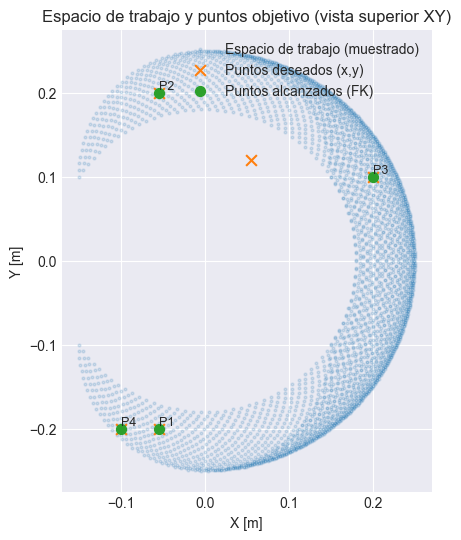

In [25]:
# ======================================================
# 3.3 Visualización en el plano XY (espacio de trabajo + puntos)
# ======================================================

def compute_workspace_samples(n_q1: int = 60, n_q2: int = 60):
    q1_vals = np.linspace(QLIM_1[0], QLIM_1[1], n_q1)
    q2_vals = np.linspace(QLIM_2[0], QLIM_2[1], n_q2)
    xs, ys = [], []
    for q1 in q1_vals:
        for q2 in q2_vals:
            x, y, _ = fk_scara_planar(q1, q2, 0.0)
            xs.append(x)
            ys.append(y)
    return np.array(xs), np.array(ys)

ws_x, ws_y = compute_workspace_samples()

fig, ax = plt.subplots(figsize=(6, 6))
ax.set_title("Espacio de trabajo y puntos objetivo (vista superior XY)")
ax.set_xlabel("X [m]")
ax.set_ylabel("Y [m]")
ax.set_aspect("equal", "box")

# Espacio de trabajo muestreado
ax.scatter(ws_x, ws_y, s=4, alpha=0.15, label="Espacio de trabajo (muestrado)")

# Puntos deseados
ax.scatter(df_targets["x"], df_targets["y"],
           c="tab:orange", s=60, marker="x", label="Puntos deseados (x,y)")

# Puntos alcanzados (FK desde IK)
ax.scatter(df_results["x_fk [m]"], df_results["y_fk [m]"],
           c="tab:green", s=50, marker="o", label="Puntos alcanzados (FK)")

for _, row in df_results.iterrows():
    ax.text(row["x_fk [m]"], row["y_fk [m]"], row["Punto"],
            fontsize=9, ha="left", va="bottom")

ax.legend(loc="upper right")
plt.show()


## 4. Comunicación PC–Arduino y secuencia de movimiento

En esta sección se reutiliza el **mismo esquema de comunicación** de la U3A4:

- Formato de mensaje: `q1_rad,q2_rad,d3_m\n`
- Baud rate: 115200 baudios.
- Puerto serial: configurable (por ejemplo, `COM4` en Windows).

La rutina:

1. Toma la lista de puntos objetivo (x, y, z).
2. Calcula (q1, q2, d3) con cinemática inversa.
3. Verifica con la cinemática directa la posición alcanzada.
4. Envía los valores articulares al Arduino para mover el robot.
5. (Opcional) Pide confirmación entre movimientos para mayor seguridad.


In [20]:
# ======================================================
# 4.1 Configuración del puerto serial y funciones de envío
# ======================================================

# Cambia este valor al puerto que uses en tu PC (COM3, COM4, etc.)
SERIAL_PORT = "COM14"
BAUD_RATE   = 115200

# Activa o desactiva el uso de serial desde el Notebook
USE_SERIAL = True

ser = None

if USE_SERIAL and HAS_SERIAL:
    try:
        ser = serial.Serial(SERIAL_PORT, BAUD_RATE, timeout=2)
        time.sleep(2.0)  # Espera a que se estabilice el puerto
        print(f"[OK] Conectado a {SERIAL_PORT} @ {BAUD_RATE} baudios")
    except Exception as e:
        print(f"[WARN] No se pudo abrir {SERIAL_PORT}: {e}")
        ser = None
else:
    if not HAS_SERIAL:
        print("[INFO] pyserial no está instalado. Modo simulación (sin envío real).")
    else:
        print("[INFO] USE_SERIAL=False → No se abrirá el puerto serial.")


def send_to_arduino(q1_rad: float, q2_rad: float, d3_m: float, wait_s: float = 0.05):
    """
    Envía una línea con el formato:
        q1_rad,q2_rad,d3_m\n
    reutilizando el mismo protocolo de la U3A4.
    """
    global ser

    line = f"{q1_rad:.4f},{q2_rad:.4f},{d3_m:.4f}\n"

    # Modo simulación (sin hardware o sin pyserial)
    if ser is None or not HAS_SERIAL:
        print("[SERIAL] (Simulado) TX:", line.strip())
        return

    # Envío real al Arduino
    ser.write(line.encode("ascii"))
    print("[SERIAL][TX]", line.strip())
    time.sleep(wait_s)

    # Lectura opcional de respuesta del Arduino
    try:
        n = ser.in_waiting
    except Exception:
        n = 0

    if n > 0:
        data = ser.read(n)
        text = data.decode("utf-8", errors="ignore").strip()
        if text:
            print("[SERIAL][RX]", text)


def run_ik_sequence(points, use_serial: bool = True,
                    confirm_each: bool = False,
                    pause_s: float = 1.5,
                    branch: str = "elbow_down"):
    """
    Ejecuta una secuencia de puntos objetivo:
    (x,y,z) -> IK -> FK -> envío a Arduino (opcional).
    """
    for i, p in enumerate(points, start=1):
        name = p.get("name", f"P{i}")
        x_d, y_d, z_d = p["x"], p["y"], p["z"]

        print("\n" + "="*60)
        print(f"Punto {name} ({i}/{len(points)})")
        print(f"Deseado: x={x_d:.4f} m, y={y_d:.4f} m, z={z_d:.4f} m")

        success, sol, info = ik_scara(x_d, y_d, z_d, branch_preference=branch)
        print("Resultado IK:", info)

        if not success:
            print("   → Se omite este punto (no alcanzable).")
            continue

        q1_rad, q2_rad, d3_m = sol
        fk_res = fk_scara(q1_rad, q2_rad, d3_m)

        dx = fk_res["x"] - x_d
        dy = fk_res["y"] - y_d
        dz = fk_res["z"] - z_d

        print(f"q1 = {math.degrees(q1_rad):6.2f}°   "
              f"q2 = {math.degrees(q2_rad):6.2f}°   "
              f"d3 = {d3_m*1000:6.2f} mm")

        print(f"FK -> x={fk_res['x']:.4f} m, "
              f"y={fk_res['y']:.4f} m, "
              f"z={fk_res['z']:.4f} m")

        print(f"Errores: Δx={dx*1000:.2f} mm, "
              f"Δy={dy*1000:.2f} mm, Δz={dz*1000:.2f} mm")

        if confirm_each:
            ans = input("¿Enviar este punto al robot? [s/N]: ").strip().lower()
            if ans != "s":
                print("   → Punto cancelado por el usuario.")
                continue

        if use_serial:
            send_to_arduino(q1_rad, q2_rad, d3_m)
            print(f"   → Esperando {pause_s:.1f} s para el movimiento físico...")
            time.sleep(pause_s)


[OK] Conectado a COM14 @ 115200 baudios


In [23]:
# ======================================================
# 4.2 Ejecución de la secuencia IK → robot
# ======================================================

# IMPORTANTE:
# Antes de ejecutar esta celda:
# 1) Verifica que SERIAL_PORT y BAUD_RATE coinciden con tu Arduino.
# 2) Asegúrate de que el robot pueda moverse seguro a estos puntos.

run_ik_sequence(
    points=target_points,
    use_serial=USE_SERIAL,
    confirm_each=False,   # Cambia a True si quieres confirmar cada punto a mano
    pause_s=2.0,          # Tiempo de espera entre puntos (s)
    branch="elbow_down"   # Rama preferida de solución
)



Punto P1 (1/5)
Deseado: x=-0.0550 m, y=-0.2000 m, z=0.0600 m
Resultado IK: Solución válida (elbow_up)
q1 = -62.75°   q2 = -69.46°   d3 =  50.00 mm
FK -> x=-0.0550 m, y=-0.2000 m, z=0.0600 m
Errores: Δx=-0.00 mm, Δy=0.00 mm, Δz=0.00 mm
[SERIAL][TX] -1.0952,-1.2123,0.0500
[SERIAL][RX] q1_rad=-1.4582  q2_rad=-0.9480  q3_m=0.0100  g=1  vel=1.00  -> servoQ1=30  servoQ2=180  servoQ3=28
RX line: -1.0952,-1.2123,0.0500
   → Esperando 2.0 s para el movimiento físico...

Punto P2 (2/5)
Deseado: x=-0.0550 m, y=0.2000 m, z=0.0700 m
Resultado IK: Solución válida (elbow_down)
q1 =  62.75°   q2 =  69.46°   d3 =  40.00 mm
FK -> x=-0.0550 m, y=0.2000 m, z=0.0700 m
Errores: Δx=0.00 mm, Δy=0.00 mm, Δz=0.00 mm
[SERIAL][TX] 1.0952,1.2123,0.0400
[SERIAL][RX] q1_rad=-1.0952  q2_rad=-1.2123  q3_m=0.0500  g=1  vel=1.00  -> servoQ1=30  servoQ2=180  servoQ3=141
RX line: 1.0952,1.2123,0.0400
   → Esperando 2.0 s para el movimiento físico...

Punto P3 (3/5)
Deseado: x=0.2000 m, y=0.1000 m, z=0.1000 m
Resultado IK

## 5. Generación de GIF de evidencia (cinemática inversa)

De acuerdo a la actividad:

- El GIF debe mostrar:
  - La ejecución del Notebook al seleccionar puntos y calcular la cinemática inversa.
  - El movimiento correspondiente del robot físico.

Desde el punto de vista del código, aquí se genera un **GIF de la simulación del SCARA en el plano XY**, usando las soluciones de cinemática inversa para los puntos definidos.

Para cumplir completamente el requisito, se puede:

- Usar un software de captura de pantalla (OBS, ShareX, etc.) para grabar:
  - La ejecución del Notebook.
  - El video del robot físico moviéndose a las posiciones.
- Integrar ese material visual en el informe y/o subirlo a la carpeta `media/` del repositorio.

A continuación se genera un GIF de la simulación, guardado en `media/ik_sequence.gif`.


In [40]:
# ======================================================
# 5.1 Generación de GIF de simulación IK en plano XY
# ======================================================

def draw_planar_robot(ax, q1_rad, q2_rad,
                      color_links="tab:blue"):
    """
    Dibuja el SCARA 2R en el plano XY para una configuración (q1,q2).
    """
    x0, y0 = 0.0, 0.0
    x1 = L1 * math.cos(q1_rad)
    y1 = L1 * math.sin(q1_rad)
    x2 = x1 + L2 * math.cos(q1_rad + q2_rad)
    y2 = y1 + L2 * math.sin(q1_rad + q2_rad)

    ax.plot([x0, x1], [y0, y1], "-o", color=color_links)
    ax.plot([x1, x2], [y1, y2], "-o", color=color_links)
    ax.scatter([x2], [y2], c="red", s=40, label="Efector final")


def generate_ik_gif(points, gif_path="media/ik_sequence.gif",
                    branch="elbow_down", duration=2000):
    """
    Genera un GIF donde se visualiza el movimiento del SCARA
    hacia cada punto objetivo usando IK.

    IMPORTANTE:
    - Se genera UNA frame por punto objetivo (P1, P2, P3, ...).
    - Gracias a frame.copy(), ahora cada frame queda "congelada" y
      el GIF realmente muestra posiciones distintas (ya no todas iguales).
    """
    os.makedirs(os.path.dirname(gif_path), exist_ok=True)

    frames = []
    fig, ax = plt.subplots(figsize=(5, 5))

    for idx, p in enumerate(points):
        x_d, y_d, z_d = p["x"], p["y"], p["z"]

        success, sol, info = ik_scara(x_d, y_d, z_d,
                                      branch_preference=branch)

        ax.clear()
        ax.set_title(f"Movimiento IK – {p['name']} ({idx+1}/{len(points)})")
        ax.set_xlabel("X [m]")
        ax.set_ylabel("Y [m]")
        ax.set_aspect("equal", "box")
        ax.grid(True, linestyle="--", alpha=0.3)

        # Espacio de trabajo (de fondo)
        ax.scatter(ws_x, ws_y, s=3, alpha=0.12, color="gray")

        # Punto deseado
        ax.scatter([x_d], [y_d], c="tab:orange", s=60,
                   marker="x", label="Objetivo")

        subtitle = info

        if success:
            q1_rad, q2_rad, d3_m = sol
            fk_res = fk_scara(q1_rad, q2_rad, d3_m)
            x_a, y_a = fk_res["x"], fk_res["y"]
            draw_planar_robot(ax, q1_rad, q2_rad)
            ax.scatter([x_a], [y_a], c="tab:green", s=40,
                       marker="o", label="Efector (FK)")
        else:
            subtitle = "Sin solución IK válida"

        ax.legend(loc="upper right")
        ax.text(0.02, 0.02, subtitle,
                transform=ax.transAxes,
                fontsize=9,
                bbox=dict(boxstyle="round",
                          fc="white", alpha=0.7))

        # Convertir la figura actual en un frame (array numpy)
        fig.canvas.draw()
        buf = fig.canvas.buffer_rgba()
        frame = np.frombuffer(buf, dtype=np.uint8)
        w, h = fig.canvas.get_width_height()
        frame = frame.reshape((h, w, 4))  # RGBA

        # ⚠️ CLAVE: hacemos copy() para que cada frame quede independiente
        frames.append(frame.copy())

    imageio.mimsave(gif_path, frames, duration=duration)
    plt.close(fig)
    return gif_path


gif_path = generate_ik_gif(target_points,
                           gif_path="media/ik_sequence.gif",
                           branch="elbow_down",
                           duration=2000)

print(f"[OK] GIF generado en: {gif_path}")


[OK] GIF generado en: media/ik_sequence.gif


## 6. Cierre del Notebook y notas para el reporte

- Se ha implementado la **cinemática inversa** del SCARA RRP a partir del modelo de cinemática directa.
- Se consideraron:
  - **Restricciones del espacio de trabajo** (rango en XY).
  - **Límites articulares** de q1, q2 y d3 definidos en `scara_kinematics.py`.
  - La existencia de dos soluciones (codo arriba / codo abajo), seleccionando por defecto **codo abajo**.
- Se verificó numéricamente IK → FK mostrando los errores de posición Δx, Δy, Δz.
- Se reutilizó el **mismo protocolo de comunicación** PC–Arduino que en la U3A4.
- Se generó un **GIF de simulación** de la cinemática inversa en el plano XY, guardado en `media/ik_sequence.gif`.

Para el PDF del proyecto U3A5, puedes incluir:

- Capturas de las tablas de resultados del Notebook.
- Capturas de las gráficas del espacio de trabajo y del GIF.
- Un resumen de las ecuaciones de cinemática inversa (sin todo el desarrollo).
- Fotografías o frames del robot físico alcanzando las posiciones seleccionadas.


In [51]:
# ======================================================
# 6.1 Cierre ordenado del puerto serial (si está abierto)
# ======================================================

if ser is not None:
    try:
        ser.close()
        print("[OK] Puerto serial cerrado correctamente.")
    except Exception as e:
        print("[WARN] Error al cerrar el puerto serial:", e)
else:
    print("[INFO] No hay puerto serial abierto que cerrar.")


[OK] Puerto serial cerrado correctamente.
